In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fetch_stock_data(ticker, start_date):
    """
    Fetch daily stock price data using yfinance.

    Parameter:
    ticker: Stock ticker symbol
    start_date: Start date for data retrieval (format: 'YYYY-MM-DD')

    Return:
    stock_data: DataFrame containing the stock's historical price data
    """
    # Get current date to serve as the end date
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    # Download the stock price data from yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    return stock_data

def moving_average_crossover_strategy(data, short_window=50, long_window=200):
    """
    Generate trading signals based on the Moving Average Crossover strategy, print entry/exit prices, 
    and calculate the revenue for each trade.

    Parameter:
    data: DataFrame containing stock price data with a 'Close' column
    short_window: Number of days for the short moving average
    long_window: Number of days for the long moving average
    
    Return:
    signals: DataFrame containing the stock's price, moving averages, and buy/sell signals
    short_window: Shorter moving average period of trend 
    long_window: Longer moving average period of trend
    """
    # Create a DataFrame to hold the stock price and moving averages
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    
    # Calculate short and long moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signals: 1.0 = Buy, 0.0 = Hold/Sell
    signals['signal'] = 0.0
    signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
        signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0, 0.0
    )

    # Calculate positions: 1.0 = Buy, -1.0 = Sell
    signals['positions'] = signals['signal'].diff()

    # Extract buy and sell signals with corresponding prices
    buy_signals = signals.loc[signals['positions'] == 1.0]
    sell_signals = signals.loc[signals['positions'] == -1.0]

    # Ensure there's a matching number of buys and sells
    paired_signals = min(len(buy_signals), len(sell_signals))

    total_revenue = 0

    # Print the buy and sell prices and calculate revenue for each trade
    for i in range(paired_signals):
        buy_date = buy_signals.index[i]
        sell_date = sell_signals.index[i]
        
        buy_price = buy_signals['price'].iloc[i]
        sell_price = sell_signals['price'].iloc[i]

        revenue = sell_price - buy_price
        total_revenue += revenue

        print(f"Trade {i + 1}:")
        print(f"  Buy on {buy_date.date()}: Price = {buy_price:.2f}")
        print(f"  Sell on {sell_date.date()}: Price = {sell_price:.2f}")
        print(f"  Revenue from this trade: {revenue:.2f}")
        print("-" * 30)

    print(f"Total Revenue from all trades: {total_revenue:.2f}")

    return signals, short_window, long_window

def plot_signals(ticker, signals, short_window, long_window):
    """
    Plot stock prices and the corresponding buy/sell signals based on the Moving Average Crossover strategy.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot the stock's closing price
    plt.plot(signals.index, signals['price'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot the short and long moving averages
    plt.plot(signals.index, signals['short_mavg'], label=f'{short_window}-Day Moving Average', color='orange', alpha=0.75)
    plt.plot(signals.index, signals['long_mavg'], label=f'{long_window}-Day Moving Average', color='green', alpha=0.75)
    
    # Plot Buy signals
    plt.plot(signals.loc[signals['positions'] == 1.0].index, 
             signals['short_mavg'][signals['positions'] == 1.0], 
             '^', markersize=10, color='g', label='Buy Signal', lw=0)
    
    # Plot Sell signals
    plt.plot(signals.loc[signals['positions'] == -1.0].index, 
             signals['short_mavg'][signals['positions'] == -1.0], 
             'v', markersize=10, color='r', label='Sell Signal', lw=0)
    
    # Plot formatting
    plt.title(f'{ticker} Stock Price with Moving Average Crossover Strategy Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed


Trade 1:
  Buy on 2018-03-15: Price = 21.71
  Sell on 2018-03-29: Price = 17.74
  Revenue from this trade: -3.96
------------------------------
Trade 2:
  Buy on 2018-07-30: Price = 19.34
  Sell on 2018-09-11: Price = 18.63
  Revenue from this trade: -0.72
------------------------------
Trade 3:
  Buy on 2018-12-03: Price = 23.90
  Sell on 2019-02-28: Price = 21.33
  Revenue from this trade: -2.57
------------------------------
Trade 4:
  Buy on 2019-11-05: Price = 21.15
  Sell on 2021-07-09: Price = 218.98
  Revenue from this trade: 197.84
------------------------------
Trade 5:
  Buy on 2021-08-30: Price = 243.64
  Sell on 2022-05-26: Price = 235.91
  Revenue from this trade: -7.73
------------------------------
Trade 6:
  Buy on 2023-06-23: Price = 256.60
  Sell on 2024-02-01: Price = 188.86
  Revenue from this trade: -67.74
------------------------------
Total Revenue from all trades: 115.11


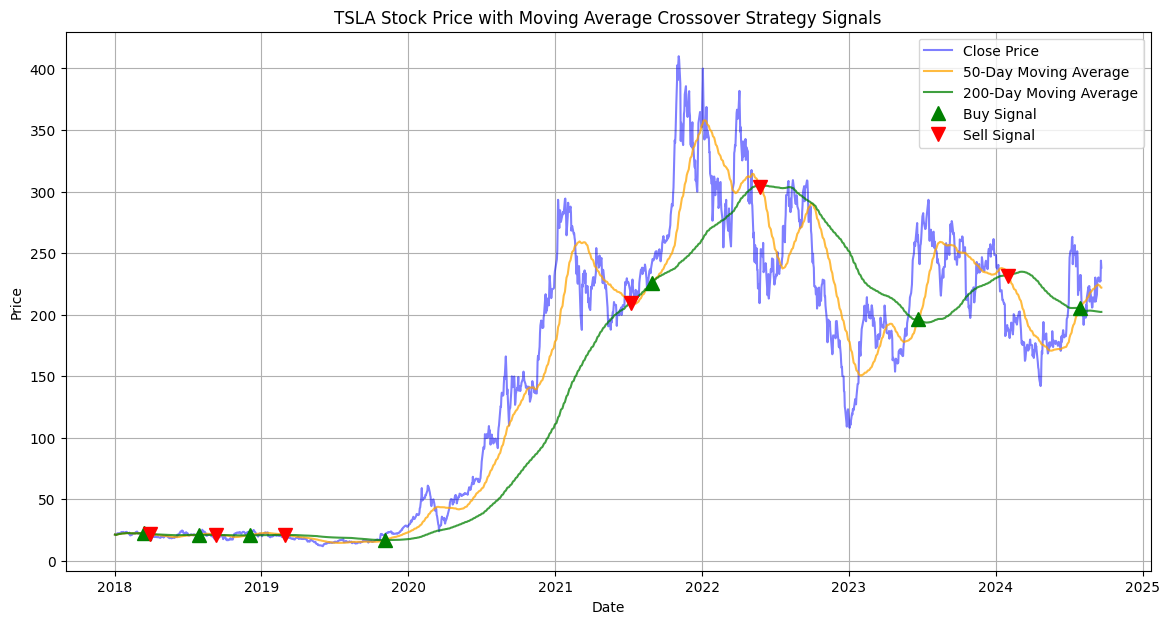

In [9]:
# Example usage
ticker = "TSLA" 
start_date = "2018-01-01" 

# Fetch the stock data
stock_data = fetch_stock_data(ticker, start_date)

# Run the moving average crossover strategy
signals, short_window, long_window = moving_average_crossover_strategy(stock_data)

# Plot the signals
plot_signals(ticker, signals, short_window, long_window)